In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
batch_size = 100
samples = 300
NUM_BATCHES = 1000
lr = 0.0001
h=1e-2
circles = 180
noise = 0.60
np.random.seed(1234)
tf.set_random_seed(1234)

In [3]:
def variable_summaries(var, name):
  """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
  with tf.name_scope(name):
    mean = tf.reduce_mean(var)
    tf.summary.scalar('mean', mean)
    with tf.name_scope('stddev'):
      stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
    tf.summary.scalar('stddev', stddev)
    tf.summary.scalar('max', tf.reduce_max(var))
    tf.summary.scalar('min', tf.reduce_min(var))
    tf.summary.histogram('histogram', var)

In [4]:
def create_spirals(samples,circles,noise):
    n = np.sqrt(np.random.rand(samples,1)) * circles * (2*np.pi)/360
    x1 = np.cos(n)*n + np.random.rand(samples,1) * noise
    x2 = np.sin(n)*n + np.random.rand(samples,1) * noise
#     x1 = n + np.random.rand(samples,1) * noise
#     x2 = n + np.random.rand(samples,1) * noise
    Spiral1 = np.hstack((x1,x2))
    Spiral2 = np.hstack((-x1,-x2))
    Spirals = np.vstack((Spiral1,Spiral2))
    Y = np.hstack((np.zeros(samples),np.ones(samples)))
    plt.title("Spirals")
    plt.plot(Spiral1[0:-1,0], Spiral1[0:-1,1], ".", label="Spiral 1", alpha=0.5)
    plt.plot(Spiral2[0:-1,0], Spiral2[0:-1,1], ".", label="Spiral 2", alpha=0.5)
    return Spirals,Y,Spiral1,Spiral2

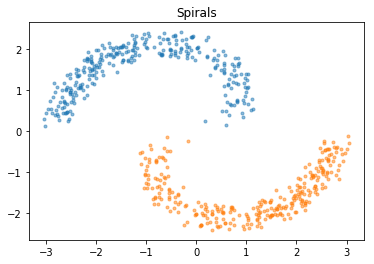

In [5]:
Spirals, Y,Spiral1,Spiral2 = create_spirals(samples,circles,noise)

In [6]:
def init_weights(num_weights,sizes):
    weights_dict = {}
    biases_dict ={}
    for i in range(num_weights):
        nameW = "w{}".format(i)
        nameB = "b{}".format(i)
        weights_dict[nameW] = tf.get_variable(nameW, sizes[i], tf.float32, tf.truncated_normal_initializer())
        biases_dict[nameW] = tf.get_variable(nameB, [1,sizes[i][1]], tf.float32, tf.zeros_initializer())
        variable_summaries(weights_dict[nameW], nameW)        
        variable_summaries(biases_dict[nameW], nameB)
    return weights_dict,biases_dict

In [7]:
def f(weights_dict,biases_dict,x):
    for weight in weights_dict:
        if weight == "w0":
            #pre sigmoid
            y_hatPS = tf.matmul(x,weights_dict[weight]) + biases_dict[weight]
        else:
            y_hatPS = tf.matmul(tf.nn.elu(y_hatPS),weights_dict[weight]) + biases_dict[weight]
    return y_hatPS
        

In [8]:
weights_dictionary, biases_dictionary = init_weights(3,[(2,16),(16,16),(16,1)])

In [9]:
def train(weights_dictionary,biases_dictionary,iteration):
    a = tf.placeholder(tf.float32, [batch_size,2])
    b = tf.placeholder(tf.float32,[batch_size,1])
    y_hat = f(weights_dictionary,biases_dictionary,a)
    #eventually add the matrix
    loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=b, logits=y_hat))
    tf.summary.scalar("Loss", loss)
    variable_summaries(y_hat, 'yhat')
    optim = tf.train.GradientDescentOptimizer(lr).minimize(loss)
    init = tf.global_variables_initializer()
    sess = tf.Session()
    sess.run(init)
    merged = tf.summary.merge_all()
    train_writer = tf.summary.FileWriter("./train{}".format(iteration), sess.graph)
    for i in tqdm(range(0,NUM_BATCHES)):
        choices = np.random.choice(samples*2,batch_size)
        x_np = Spirals[choices]
        y_np = np.array(Y[choices]).reshape((batch_size,1))
        loss_np, _ = sess.run([loss, optim], feed_dict={a: x_np, b: y_np})
        summary = sess.run(merged, feed_dict={a:x_np, b:y_np})
        train_writer.add_summary(summary,i)
        if i<10 or i>(NUM_BATCHES-10):
            print(loss_np)
    return sess

In [10]:
sess =train(weights_dictionary,biases_dictionary,0)

  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

8.974428


  0%|                                                                                 | 1/1000 [00:00<02:07,  7.83it/s]

9.729857
8.913125
9.1586
9.215231
9.900557
10.083744
7.953993
8.320392
9.05457


 99%|█████████████████████████████████████████████████████████████████████████████▎| 991/1000 [00:05<00:00, 170.26it/s]

0.3312793
0.20331521
0.2651712
0.37186632
0.32809654
0.46212974
0.33150384
0.33710244
0.46344036


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 169.57it/s]


In [11]:
samples

300

100%|█████████████████████████████████████████████████████████████████████████████| 1400/1400 [00:04<00:00, 291.35it/s]


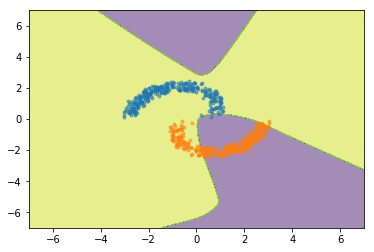

In [12]:
xx,yy = np.meshgrid(np.arange(-7,7,h), np.arange(-7,7,h))
inputx = np.stack((xx,yy), axis=2)
y_hats = np.array([])
c = tf.placeholder(tf.float32, [inputx.shape[0],2])
y_hat = f(weights_dictionary,biases_dictionary,c)

for i in tqdm(range(inputx.shape[0])):
    if y_hats.size>0: 
        y_hats = np.hstack((y_hats,sess.run(y_hat,{c: inputx[i]})))
    else: 
        y_hats = sess.run(y_hat,{c:inputx[i]})
    
y_hats[y_hats>0] = 1
y_hats[y_hats<=0] = 0
plt.contourf(xx,yy,y_hats,alpha=0.5)
plt.plot(Spiral1[0:-1,0], Spiral1[0:-1,1], ".", label="Spiral 1", alpha=0.5)
plt.plot(Spiral2[0:-1,0], Spiral2[0:-1,1], ".", label="Spiral 2", alpha=0.5)